# Use of pre-trained model

Here we use MobileNet pre-trained model for transfer learning to increase the accuracy of our model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil #moving files form one to another
import glob
import tensorflow as tf

In [3]:
# counting the number of images in each folder
# 0 - Braintumor 1- Healthey
ROOT_DIR = 'Brain Tumor Data Set\Brain Tumor Data Set'
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Brain Tumor', 17), ('Healthy', 16)])

In [4]:
len(os.listdir(ROOT_DIR))

2

# We will split the data set into
* 70% for training
* 15% for validation
* 15% for validation
    

In [5]:
#Creating a function for the splitting

def split_data(path,split):
    if not os.path.exists("./"+path):
        os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
        os.makedirs("./"+path+"/"+ dir) #creating multiple folders
        
        for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR,dir)),size=(math.floor(split*number_of_images[dir])-5),replace=False):
            O = os.path.join(ROOT_DIR,dir,img)
            D = os.path.join("./"+path,dir)
            shutil.copy(O,D)
            os.remove(O)
    else:
        print(f"{path}folder already exists")


 

In [6]:
split_data("train",0.7)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './train/Brain Tumor'

In [7]:
split_data("test",0.15)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './test/Brain Tumor'

In [8]:
split_data("val",0.15)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './val/Brain Tumor'

# Model building

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input # MobileNet is a pre-trained model

Data preparation

In [19]:
def preProcessingImages1(path):
    '''
    input : Path
    output : Pre Processed Images
    '''
    

    image_data = ImageDataGenerator(preprocessing_function=preprocess_input, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) # Data Augmentation
    image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode='binary')

    return image

In [20]:
path = "train"
train_data = preProcessingImages1(path)

Found 3209 images belonging to 2 classes.


In [21]:
# Class indicies

train_data.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

In [22]:
def preProcessingImages2(path):
    '''
    input : Path
    output : Pre Processed Images
    '''
    

    image_data = ImageDataGenerator(preprocessing_function=preprocess_input) # Data Augmentation
    image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode='binary')

    return image

In [23]:
path = "test"
test_data = preProcessingImages2(path)

Found 679 images belonging to 2 classes.


In [24]:
path = "val"
val_data = preProcessingImages2(path)

Found 679 images belonging to 2 classes.


In [72]:
# Early stopping and model checkpoint

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early stopping

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=6, verbose=1)

# model checkpoint

mc = ModelCheckpoint(filepath= './bestmodel.keras', monitor='val_accuracy', verbose=1, save_best_only=True)

cb = [es,mc]

# Model Training


In [25]:
# importing the pre-trained model and other libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense # Here the Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D are already used in the pre-trained model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.mobilenet import MobileNet# MobileNet is a pre-trained model



In [26]:
base_model = MobileNet(input_shape=(224,224,3), include_top=False) # include_top=False means that we are not including the top layer of the model

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 59s 3us/step


In [27]:
#make sure of not detraining
for layer in base_model.layers:
    layer.trainable = False


In [30]:
# Adding Flatten and Dense layer to the model

X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)

model = Model(base_model.input, X)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,279,041 (12.51 MB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [31]:
# Compile the model

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training

In [73]:
hist = model.fit(train_data, validation_data=val_data, steps_per_epoch=8, epochs=10, validation_steps=16, callbacks=cb)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.6444 - loss: 3.9979
Epoch 1: val_accuracy improved from -inf to 0.91211, saving model to ./bestmodel.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6567 - loss: 3.8409 - val_accuracy: 0.9121 - val_loss: 0.6851
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.9013 - loss: 0.7998
Epoch 2: val_accuracy did not improve from 0.91211
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8905 - loss: 0.9553 - val_accuracy: 0.5569 - val_loss: 7.5945
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.7667 - loss: 2.4876
Epoch 3: val_accuracy improved from 0.91211 to 0.92383, saving model to ./bestmodel.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7774 - loss: 2.3394 - val_accuracy: 0.9238 - val_loss: 0.5785
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8615 - loss: 1.2931
Epoch 4: val_accuracy did not improve from 0.92383
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy:

In [74]:
# Graphical interpretation of the model

h = hist.history
h.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

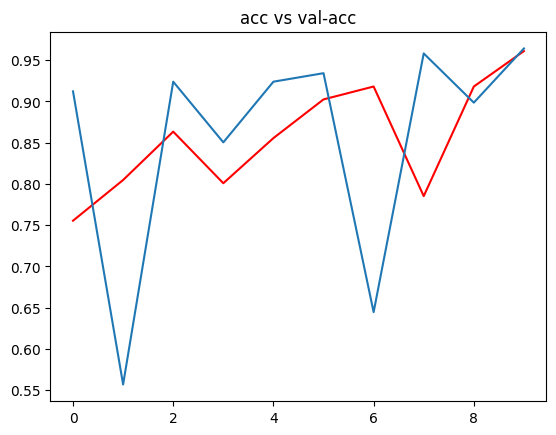

In [75]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy'], c='red')
plt.plot(h['val_accuracy'])

plt.title("acc vs val-acc")
plt.show()

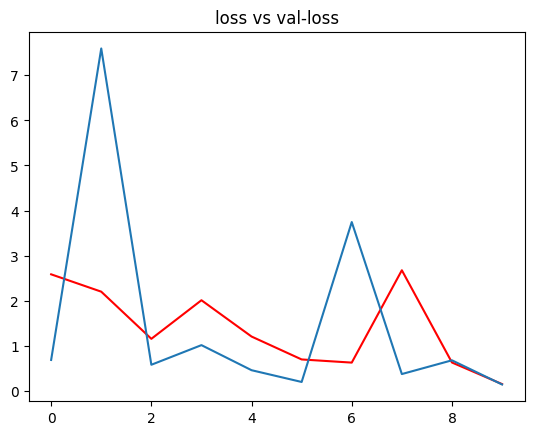

In [76]:
import matplotlib.pyplot as plt
plt.plot(h['loss'], c='red')
plt.plot(h['val_loss'])

plt.title("loss vs val-loss")
plt.show()

# Model Accuracy

In [77]:
from tensorflow.keras.models import load_model

model = load_model('bestmodel.keras')

In [78]:
# Model Accuracy

acc = model.evaluate(test_data)

print(f"The accuracy of the model is {acc[1]*100} %")

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 436ms/step - accuracy: 0.9562 - loss: 0.2158
The accuracy of the model is 95.87628841400146 %


In [79]:
#from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image

In [80]:
def inputImage(path):
    '''
    input : Path
    output : Image
    '''
    
    img = image.load_img(path, target_size=(224,224))

    i = image.img_to_array(img)/255
    input_arr = np.expand_dims(i, axis=0)
    
    return input_arr

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
This MRI is Healthy


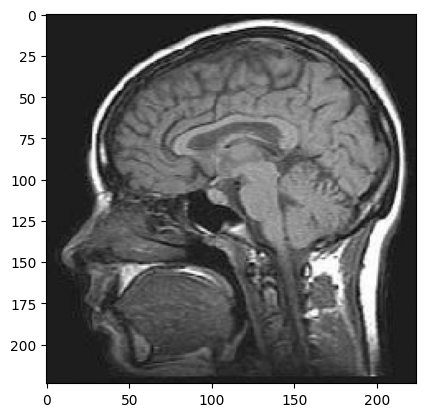

In [81]:
# path="Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (269).jpg"

# img = load_img(path, target_size=(224,224))
# input_arr = img_to_array(img)/255 # Normalization

# input_arr = np.expand_dims(input_arr, axis=0)
# plt.imshow(input_arr[0])
# plt.show()
image_arr = inputImage("Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (302).jpg")

prediction = model.predict(image_arr)[0][0]
#prediction = np.argmax(model.predict(image_arr)[0][0])
#print(prediction)

if prediction < 0.2:
     print("This MRI is a Brain Tumor")
elif prediction > 0.8:
     print("This MRI is Healthy")

plt.imshow(image_arr[0])
plt.show()